In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import nibabel as nib
from os import path
from scipy.cluster import hierarchy

In [2]:
def wasserstein(mu1, var1, mu2, var2):
    return np.sqrt(
        ( mu1 - mu2 )**2 + ( np.sqrt(var1) - np.sqrt(var2) )**2
    )

def wasserstein_matrix(mu1, var1, mu2, var2):
    #print( np.trace( var1 ), np.trace( var2 ), np.trace(- 2 * np.transpose( np.transpose(var2) @ var1 @ np.transpose(var2) ) ) )
    return np.sqrt(
        np.linalg.norm( mu1.flatten() - mu2.flatten() )**2 + np.sum(
            var1 + var2 - 2 * np.sqrt( var1 * var2 )
        )
    )

def kullback(mu0, var0, mu1, var1):
    return 0.5 * (
        var0 / var1 + (mu1 - mu0)**2 / var1 - 1 + 2 * np.log( np.sqrt(var1 / var0) )
    )

def hellinger(mu1, var1, mu2, var2):
    return 1 - np.sqrt(2 * np.sqrt(var1 * var2)) / (var1 + var2) * np.exp(
        - 0.25 * (mu1 - mu2)**2 / (var1 + var2)
    )

In [3]:
subjectPath = '../../../Data/OpenfMRI/ds000115_R2.0.0/sub-{0:02d}'
gaussianPath = subjectPath + '/func/sub-{0:02d}_task-letter{1:d}backtask_bold-{2:s}.nii'

In [15]:
subjects = np.arange(1, 102 + 1)
backtasks = np.arange(0, 2 + 1)
distanceMatrix = np.zeros((102, 102, 3))
for i,subject1 in enumerate(subjects):
    if not path.exists(subjectPath.format(subject1)):
        continue

    for j,subject2 in enumerate(subjects):
        if i < j:
            continue

        if not path.exists(subjectPath.format(subject2)):
            continue

        for backtask in backtasks:
            if subject1 == 1:
                meanFile1 = nib.load(gaussianPath.format(subject1, backtask, 'mean'))
                varianceFile1 = nib.load(gaussianPath.format(subject1, backtask, 'variance'))
            else:
                meanFile1 = nib.load(gaussianPath.format(subject1, backtask, 'mean-registered'))
                varianceFile1 = nib.load(gaussianPath.format(subject1, backtask, 'variance-registered'))

            if subject2 == 1:
                meanFile2 = nib.load(gaussianPath.format(subject2, backtask, 'mean'))
                varianceFile2 = nib.load(gaussianPath.format(subject2, backtask, 'variance'))
            else:
                meanFile2 = nib.load(gaussianPath.format(subject2, backtask, 'mean-registered'))
                varianceFile2 = nib.load(gaussianPath.format(subject2, backtask, 'variance-registered'))

            mean1 = meanFile1.get_fdata()
            variance1 = varianceFile1.get_fdata()

            mean2 = meanFile2.get_fdata()
            variance2 = varianceFile2.get_fdata()

            distances = wasserstein_matrix(mean1.flatten(), variance1.flatten(), mean2.flatten(), variance2.flatten())

            distanceMatrix[i, j, backtask] = distances
            distanceMatrix[j, i, backtask] = distances

        print('finished comparing {:d} with {:d}'.format(subject1, subject2))


finished comparing 1 with 1
finished comparing 2 with 1
finished comparing 2 with 2
finished comparing 3 with 1
finished comparing 3 with 2
finished comparing 3 with 3
finished comparing 4 with 1
finished comparing 4 with 2
finished comparing 4 with 3
finished comparing 4 with 4
finished comparing 5 with 1
finished comparing 5 with 2
finished comparing 5 with 3
finished comparing 5 with 4
finished comparing 5 with 5
finished comparing 6 with 1
finished comparing 6 with 2
finished comparing 6 with 3
finished comparing 6 with 4
finished comparing 6 with 5
finished comparing 6 with 6
finished comparing 7 with 1
finished comparing 7 with 2
finished comparing 7 with 3
finished comparing 7 with 4
finished comparing 7 with 5
finished comparing 7 with 6
finished comparing 7 with 7
finished comparing 8 with 1
finished comparing 8 with 2
finished comparing 8 with 3
finished comparing 8 with 4
finished comparing 8 with 5
finished comparing 8 with 6
finished comparing 8 with 7
finished comparing 8

In [16]:
distanceMatrixNormalized = distanceMatrix / distanceMatrix.max()
np.save('../../../Data/OpenfMRI/ds000115_R2.0.0/comparative-subjects-matrix.npy', distanceMatrix)
np.save('../../../Data/OpenfMRI/ds000115_R2.0.0/comparative-subjects-matrix-normalized.npy', distanceMatrixNormalized)


In [3]:
distanceMatrixNormalized = np.load('../../../Data/OpenfMRI/ds000115_R2.0.0/comparative-subjects-matrix-normalized.npy')

In [4]:
# remove empty subjects 23, 25, 48
distanceMatrixNormalizedCleared = np.delete(distanceMatrixNormalized, [22,24,47], axis=0)
distanceMatrixNormalizedCleared = np.delete(distanceMatrixNormalizedCleared, [22,24,47], axis=1)

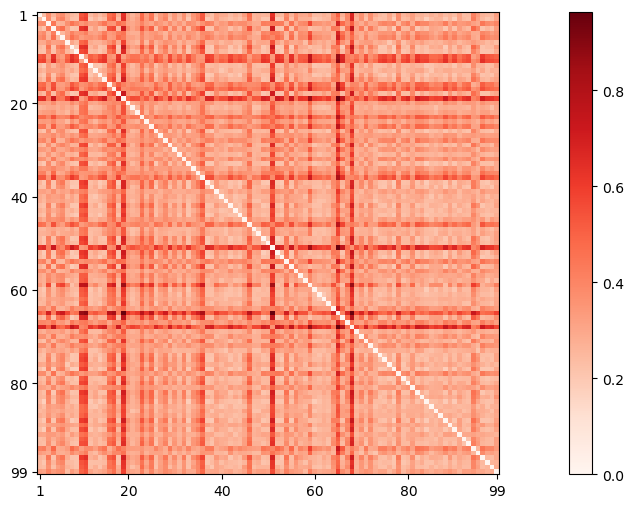

In [5]:
plt.figure(figsize=(18,6))
plt.imshow(distanceMatrixNormalizedCleared[:,:,2], cmap='Reds', interpolation='none')
plt.xticks([0, 19, 39, 59, 79, 98], [1, 20, 40, 60, 80, 99])
plt.yticks([0, 19, 39, 59, 79, 98], [1, 20, 40, 60, 80, 99])
plt.colorbar()
plt.show()

In [6]:
maximalBasis = np.argmax( np.sum( distanceMatrixNormalized[:,:,0], axis=0 ) )
print( 'Basis {:d} has the most differences'.format(maximalBasis) )
maximumPair = np.argmax(distanceMatrixNormalized[maximalBasis,:,0])
print( 'Maximal differ pair is {:d} - {:d}'.format(maximalBasis, maximumPair) )

Basis 18 has the most differences
Maximal differ pair is 18 - 67


In [7]:
np.unravel_index(np.argmax( distanceMatrixNormalized ), distanceMatrixNormalized.shape)

(18, 67, 1)

In [8]:
def clean_condition(entry):
    if entry == 'CON':
        return 1
    elif entry == 'CON-SIB':
        return 0.5
    elif entry == 'SCZ-SIB':
        return 1.5
    elif entry == 'SCZ':
        return 2
    else:
        return 0

participants = pd.read_csv('../../../Data/OpenfMRI/ds000115_R2.0.0/participants.tsv', sep=r'\t', header=0)
participants['Condition'] = participants['condit'].apply(clean_condition)
#participants['ID'] = participants['participant_id'].apply(lambda row: np.int64(row[-2:]))
#participants.index = participants['ID']
#participants = participants.drop('ID', axis=1)

print(participants)

   participant_id   condit  gender   race      age  yrschool  saps7  saps20  \
0          sub-01      SCZ    MALE  WHITE  28.9610        12      0       2   
1          sub-02  SCZ-SIB    MALE  WHITE  26.8419        16      0       0   
2          sub-03  SCZ-SIB  FEMALE  WHITE  29.4648        18      1       1   
3          sub-04  SCZ-SIB    MALE  WHITE  25.8344        18      0       0   
4          sub-05      SCZ  FEMALE  WHITE  25.6454        14      2       2   
..            ...      ...     ...    ...      ...       ...    ...     ...   
94         sub-98  CON-SIB  FEMALE  WHITE  21.0240        14      0       0   
95         sub-99      SCZ    MALE  WHITE  26.2177        11      3       2   
96        sub-100  SCZ-SIB  FEMALE  WHITE  28.9938        13      0       0   
97        sub-101      CON    MALE  WHITE  27.9069        16      0       0   
98        sub-102      CON    MALE     AA  27.6797        19      0       0   

      saps25  saps34  ...  nback1_targ  nback2_nont

/tmp/ipykernel_18725/2299211742.py:13: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  participants = pd.read_csv('../../../Data/OpenfMRI/ds000115_R2.0.0/participants.tsv', sep=r'\t', header=0)


In [9]:
participantsSorted = participants.sort_values(by=['Condition', 'age'])
sorting = participantsSorted.index
participantsSorted

,participant_id,condit,gender,race,age,yrschool,saps7,saps20,saps25,saps34,...,nback1_targ,nback2_nont,nback2_targ,nback0_nont_medrt,nback0_targ_medrt,nback1_nont_medrt,nback1_targ_medrt,nback2_nont_medrt,nback2_targ_medrt,Condition
35,sub-38,CON-SIB,MALE,AA,11.6687,3,0,0,0.0,0,...,0.916667,1.000000,0.916667,744.5,721.0,760.0,667.0,809.0,665.0,0.5
44,sub-47,CON-SIB,FEMALE,AA,12.3696,6,0,0,0.0,0,...,0.750000,0.800000,0.416667,831.0,881.0,1178.0,1033.0,1304.0,1308.0,0.5
83,sub-87,CON-SIB,FEMALE,WHITE,15.4716,9,0,0,0.0,0,...,0.833333,1.000000,1.000000,599.0,642.0,608.0,675.5,703.5,673.5,0.5
15,sub-16,CON-SIB,FEMALE,AA,16.9199,10,0,0,0.0,0,...,0.666667,0.964286,0.750000,843.0,903.0,901.0,991.0,975.0,960.0,0.5
85,sub-89,CON-SIB,MALE,WHITE,18.7488,12,0,0,0.0,0,...,0.750000,0.966667,0.750000,786.5,922.0,861.5,911.0,995.0,1020.0,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,sub-95,SCZ,MALE,WHITE,27.7728,14,3,4,0.0,0,...,0.833333,1.000000,0.916667,541.5,654.0,676.5,673.5,653.5,774.0,2.0
0,sub-01,SCZ,MALE,WHITE,28.9610,12,0,2,0.0,0,...,0.833333,0.933333,0.750000,624.0,674.5,812.5,895.5,777.0,724.0,2.0
75,sub-79,SCZ,MALE,WHITE,29.2156,14,0,0,0.0,0,...,1.000000,1.000000,1.000000,605.5,770.5,722.0,813.0,1028.5,928.5,2.0
73,sub-77,SCZ,FEMALE,WHITE,29.7221,12,0,0,2.0,3,...,0.833333,0.833333,0.666667,819.0,789.0,850.0,823.0,964.0,677.0,2.0


In [10]:
distanceMatrixNormalizedClearedSorted = distanceMatrixNormalizedCleared[sorting,:,:]
distanceMatrixNormalizedClearedSorted = distanceMatrixNormalizedClearedSorted[:,sorting,:]

In [163]:
np.save('../../../Data/OpenfMRI/ds000115_R2.0.0/comparative-subjects-matrix-normalized-sorted.npy', distanceMatrixNormalizedClearedSorted)

In [11]:
conditionDerivative = participantsSorted['Condition'].diff().values
conditionChanges = np.where(conditionDerivative > 0)[0]
print(conditionChanges)

[21 41 76]


In [165]:
np.save('../../../Data/OpenfMRI/ds000115_R2.0.0/comparative-subjects-condition-borders.npy', conditionChanges)

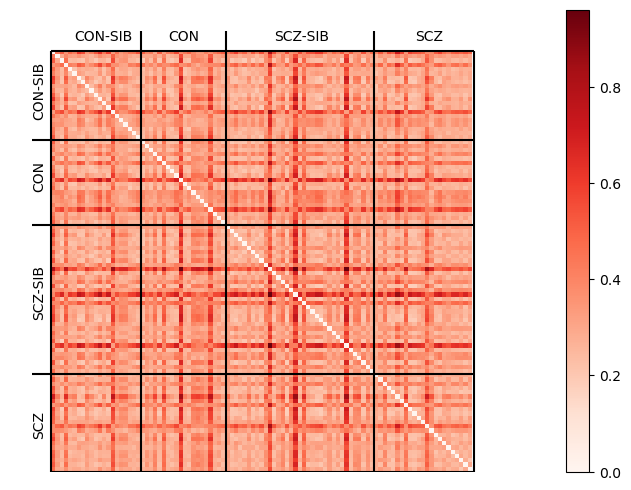

In [12]:
plt.figure(figsize=(18,6))
ax = plt.gca()
ax.axis('off')

plt.imshow(distanceMatrixNormalizedClearedSorted[:,:,2], cmap='Reds', interpolation='none')
plt.xticks([])
plt.yticks([])

plt.vlines([-0.5, distanceMatrixNormalizedClearedSorted.shape[0]], -0.5, distanceMatrixNormalizedClearedSorted.shape[1]-0.5, colors='k')
plt.hlines([-0.5, distanceMatrixNormalizedClearedSorted.shape[1]-0.5], -0.5, distanceMatrixNormalizedClearedSorted.shape[0], colors='k')

plt.vlines(conditionChanges-0.5, -5, distanceMatrixNormalizedClearedSorted.shape[1]-0.5, colors='k')
plt.hlines(conditionChanges-0.5, -5, distanceMatrixNormalizedClearedSorted.shape[0], colors='k')

plt.text(5, -3, 'CON-SIB')
plt.text(27, -3, 'CON')
plt.text(52, -3, 'SCZ-SIB')
plt.text(85, -3, 'SCZ')

plt.text(-5, 15, 'CON-SIB', dict(rotation=90))
plt.text(-5, 32, 'CON', dict(rotation=90))
plt.text(-5, 62, 'SCZ-SIB', dict(rotation=90))
plt.text(-5, 90, 'SCZ', dict(rotation=90))

plt.colorbar()
plt.show()

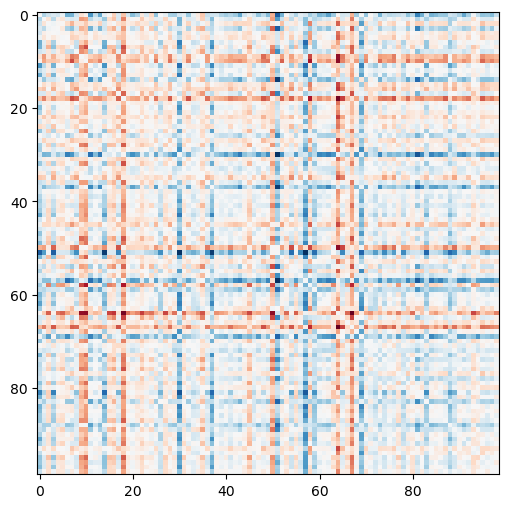

In [13]:
plt.figure(figsize=(18,6))
plt.imshow( distanceMatrixNormalizedClearedSorted[:,:,2] - distanceMatrixNormalizedCleared[:,:,2], cmap='RdBu' )
plt.show()